# error in order of cases not good

In [1]:
import pandas as pd
import time
import numpy as np
from ClusteringPredictiveModel import ClusteringPredictiveModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from  matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
from LastStateEncoder import LastStateEncoder

C:\Users\MSI\Miniconda3\envs\dl-challenge\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
data=pd.read_csv('BPIC 2017 just complete cases.csv',sep=';')

In [3]:
n_clusters = 6

In [4]:
#global case_id_col,event_col,timestamp_col,label_col,pos_label,numeric_cols,meta_event_data,other_col,variant_col

case_id_col = "Case ID"
event_col = "Activity"
timestamp_col = ["Complete Timestamp"]
label_col = 'lbl'
pos_label = 'A_Pending'
cat_cols = ['Resource','(case) LoanGoal','(case) ApplicationType'] 
numeric_cols = [ '(case) RequestedAmount',label_col]  
meta_event_data=['Start Timestamp','EventOrigin','OfferID','Unnamed: 0','Transition','milli_seconds',
          'EventID','lifecycle:transition','days','D_seconds',
          'Accepted', 'Selected' ,
          'FirstWithdrawalAmount', 'MonthlyCost', 'NumberOfTerms','outcome',
          'Variant', 'Action', 'CreditScore','OfferedAmount'
          ]
other_col= '(case) RequestedAmount'
variant_col='Variant index'

In [5]:
data.drop(meta_event_data,axis=1,inplace=True)
data.drop(variant_col,axis=1,inplace=True)

In [6]:
# divide into train and test data
np.random.seed(22)
sample_cases_KMeans = np.random.choice(data[case_id_col].unique(), len(data['Case ID'].unique()))
train_cases_KMeans, test_cases_KMeans = train_test_split(sample_cases_KMeans , train_size = 4.0/5, random_state = 22 )
train_KMeans = data[data[case_id_col].isin(train_cases_KMeans)]
test_KMeans = data[data[case_id_col].isin(test_cases_KMeans)]

C:\Users\MSI\Miniconda3\envs\dl-challenge\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [7]:
# for filling empty encoded columns                     #   one time
###################################
all_users=pd.Series(data['Resource'].values).unique()
all_goal=pd.Series(data['(case) LoanGoal'].values).unique()
all_types=pd.Series(data['(case) ApplicationType'].values).unique()
global d1

d=list(['Resource_'+str(u) for u in all_users  ])
d1=list(['(case) LoanGoal_'+str(u) for u in all_goal  ])
d2=list(['(case) ApplicationType_'+str(u) for u in all_types  ])

for i in d:
    d1.append(i)
for i in d2:
    d1.append(i)


In [8]:
# fit model (cluster traces and build classifier for each cluster)
model_clustering = ClusteringPredictiveModel(d1,case_id_col, event_col, label_col, timestamp_col, cat_cols, numeric_cols, n_clusters=n_clusters, n_estimators=100, random_state=22, fillna=True)
model_clustering.fit(train_KMeans)

# model discovery

In [60]:
#Inductive visual miner for all clusters: "Generate petri-net model for each cluster

In [47]:
test_KMeans.to_csv('test.csv',sep=";")

In [61]:
#alignment test with all clusters  ProM 6: "Alignment Xlog for DPN"

In [48]:
from pm4py.objects.log.importer.xes import factory as xes_importer
#from pm4py.evaluation.replay_fitness import factory as replay_factory
#from pm4py.algo.conformance.alignments import factory as align_factory
#from pm4py.algo.discovery.alpha import factory as alpha_miner
#from pm4py.algo.discovery.inductive import factory as inductive_miner
#from pm4py.evaluation.replay_fitness import factory as replay_fitness_factory
#from pm4py.visualization.petrinet import factory as pn_vis_factory

In [49]:
#load alignment files to array
alignments=[]
for i in range(n_clusters):
    name='clusters/align_test_'+str(i)+'.xes'
    alignments.append( xes_importer.import_log(name))

must notice the order of cases to good predict outcome

they are not in the same order of test_KMeans

In [59]:
# assigne traces to clusters
clusters_assignment=[]
for i in range(len (alignments[0])):  # for all test cases
    align=[]
    for j in range(n_clusters):       # for n cluster
        align.append(alignments[j][i].attributes['alignment:fitness'])
    clusters_assignment.append(np.argmax(align))
#free the memory
alignments=[]
print("clusters distibution: ",[clusters_assignment.count(c) for c in np.unique(clusters_assignment)])

clusters distibution:  [1196, 3683, 268, 120, 430, 9]


In [84]:
align

[0.43478262424468994,
 0.9230769276618958,
 0.8999999761581421,
 0.8064516186714172,
 0.9230769276618958,
 0.931034505367279]

In [27]:
# encoding all features 
all_encode=data
all_encode=data_encoder.transform(all_encode)
cls_features=all_encode.columns

In [73]:
data_encoder = LastStateEncoder(case_id_col, timestamp_col, cat_cols, numeric_cols, fillna=True)

In [75]:
# predicting outcome classes
cols = [case_id_col]+list(['A_Pending']+['A_Cancelled']+['A_Denied'])
# important to sort as xes log
cases_frame=test_KMeans.groupby(['Case ID']).head(1)
preds = pd.DataFrame(columns=cols)
actual = pd.DataFrame(columns=cols)
for cl in range(n_clusters):
    # select cases belonging to given cluster
    cases =list( cases_frame[np.array(clusters_assignment) == cl]['Case ID'])
    if len(cases)>0:
        tmp = test_KMeans[test_KMeans[case_id_col].isin (cases)]

        # encode data attributes
        test_encode = data_encoder.transform(tmp)
        missing_columns=[col for col in d1 if col not in test_encode.columns]#test_encode.columns
        mc=pd.DataFrame(columns=missing_columns)
        test_encode=pd.concat([test_encode,mc],ignore_index=True, sort=False).fillna(0)
        test_encode.fillna(0, inplace=True)
        # make predictions
        new_preds = pd.DataFrame(model_clustering.clss[cl].predict_proba(test_encode.drop([case_id_col, label_col], axis=1)))
        new_preds.columns =model_clustering.clss[cl].classes_
        new_preds[case_id_col] = list(cases)
        #new_preds
        preds = pd.concat([preds, new_preds], axis=0, ignore_index=True,sort=False)
        # extract actual label values
        actuals = pd.get_dummies(test_encode[label_col])
        #print(actuals)
        actuals[case_id_col] = test_encode[case_id_col]
        actual = pd.concat([actual, actuals], axis=0, ignore_index=True,sort=False)
        print(' ',len(new_preds),end='')
    else:
        print(' 0',end='')
print('')
preds.fillna(0, inplace=True)
actual.fillna(0, inplace=True)

  1196  3683  268  120  430  9


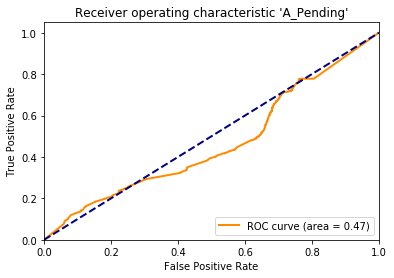

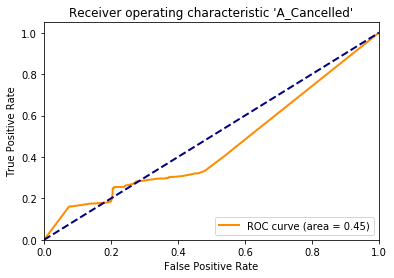

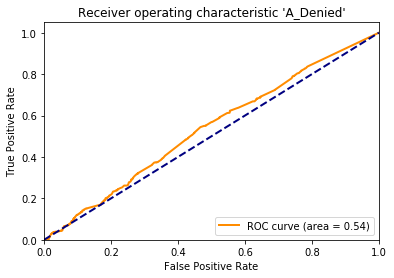

In [76]:
import sklearn.metrics as met
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
th=dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i],th[i] = met.roc_curve(actual[actual.columns.values[i+1]],preds[preds.columns.values[i+1]])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(3):
    plt.figure()
    lw = i
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic %r' %actual.columns.values[i+1])
    plt.legend(loc="lower right")
    plt.show()

# end,

In [27]:
# trim first n activity
#######################

n=12
n_events=test_KMeans.groupby(['Case ID']).apply(lambda x: x.head(n)).droplevel(1)
#n_events=pd.DataFrame(columns=test_KMeans.columns)
#for i in test_cases_KMeans:
    #cc=test_KMeans[test_KMeans['Case ID']==i]
    #n_events=n_events.append(test_KMeans[test_KMeans['Case ID']==i][0:n])
#n_events=test_KMeans[test_KMeans.index.isin(n_events.index) ]

In [120]:
# events from '''''''  to '''''''
#if not: from_event=A_Create Application

from_event= 'A_Submitted'

to_event  = 'A_Accepted'

from_to=pd.DataFrame(columns=test_KMeans.columns)
#idx=dd[dd['Activity'].values==from_event].index
#idx2=dd[dd['Activity'].values==to_event].index  
#cd=test_KMeans[test_KMeans.index.isin (range(idx[0],idx2[0]+1))]

for i in test_cases_KMeans:
    dd=test_KMeans[test_KMeans['Case ID']==i]
    idx=dd[dd['Activity'].values==from_event].index
    if not idx.any():
        idx=dd[dd['Activity'].values=='A_Create Application'].index
    idx2=dd[dd['Activity'].values==to_event].index 
    from_to=from_to.append(test_KMeans[test_KMeans.index.isin (range(idx[0],idx2[0]+1))])

In [121]:
# events from '''''''  to '''''''
#if not: from_event=A_Create Application

from_event= 'A_Accepted'

to_event  = 'O_Sent (mail and online)'

#from_to=pd.DataFrame(columns=test_KMeans.columns)
#idx=dd[dd['Activity'].values==from_event].index
#idx2=dd[dd['Activity'].values==to_event].index  
#cd=test_KMeans[test_KMeans.index.isin (range(idx[0],idx2[0]+1))]

for i in test_cases_KMeans:
    dd=test_KMeans[test_KMeans['Case ID']==i]
    idx=dd[dd['Activity'].values==from_event].index+1
    if not idx.any():
        idx=dd[dd['Activity'].values=='A_Create Application'].index+1
    idx2=dd[dd['Activity'].values==to_event].index 
    if not idx2.any():
        idx2=dd[dd['Activity'].values=='O_Sent (online only)'].index
    if not idx2.any():
        idx2=dd[dd['Activity'].values=='O_Created'].index
    from_to=from_to.append(test_KMeans[test_KMeans.index.isin (range(idx[0],idx2[0]+1))])

In [122]:
# events from '''''''  to '''''''
#if not: from_event=A_Create Application

from_event= 'A_Validating'

to_event  = 'A_Pending'

#from_to=pd.DataFrame(columns=test_KMeans.columns)
#idx=dd[dd['Activity'].values==from_event].index
#idx2=dd[dd['Activity'].values==to_event].index  
#cd=test_KMeans[test_KMeans.index.isin (range(idx[0],idx2[0]+1))]

for i in test_cases_KMeans:
    dd=test_KMeans[test_KMeans['Case ID']==i]
    idx=dd[dd['Activity'].values==from_event].index
    if not idx.any():
        idx=dd[dd['Activity'].values=='W_Call after offers'].index
    if not idx.any():
        idx=dd[dd['Activity'].values=='W_Complete application'].index
        
    if not idx.any():
        idx=dd[dd['Activity'].values=='W_Shortened completion'].index    
    
    idx2=dd[dd['Activity'].values==to_event].index 
    if not idx2.any():
        idx2=dd[dd['Activity'].values=='A_Denied'].index
    if not idx2.any():
        idx2=dd[dd['Activity'].values=='A_Cancelled'].index
    if not (idx2.any()and idx.any()):
        continue
    if not idx2.any():
        idx2=[dd.index.max()]
    from_to=from_to.append(test_KMeans[test_KMeans.index.isin (range(idx[0],idx2[0]+1))])

In [28]:
n_events.index=range(0,len(n_events))

In [29]:
len(n_events)

65360

In [9]:
# predict for test set (assign each trace to the closest cluster and predict outcome using the corresponding classifier)
preds = model_clustering.predict_proba(test_KMeans )

  1684  579  1240  1715  171  317


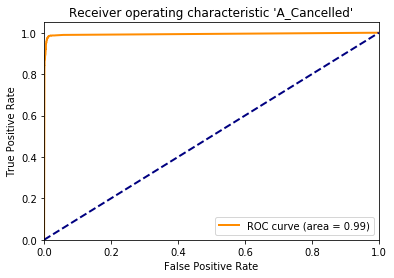

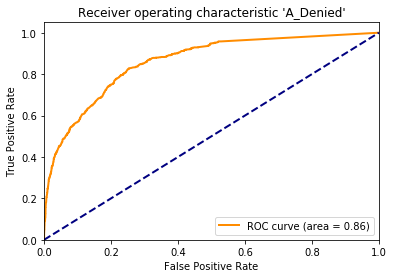

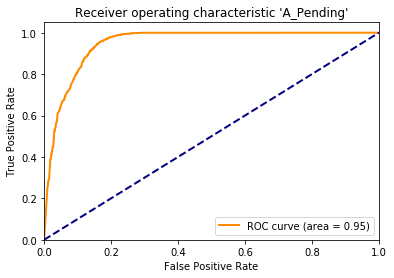

In [10]:
import sklearn.metrics as met
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
th=dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i],th[i] = met.roc_curve(model_clustering.actual[model_clustering.actual.columns.values[i+1]],preds[preds.columns.values[i+1]])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(3):
    plt.figure()
    lw = i
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic %r' %model_clustering.actual.columns.values[i+1])
    plt.legend(loc="lower right")
    plt.show()

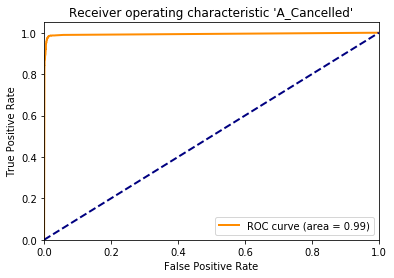

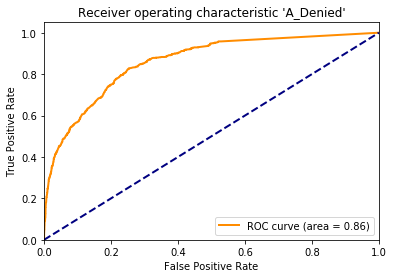

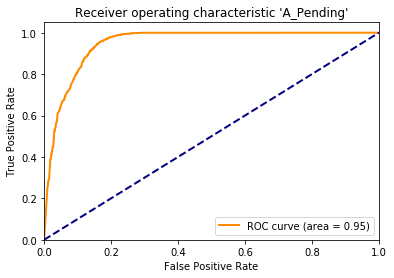

In [10]:
import sklearn.metrics as met
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
th=dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i],th[i] = met.roc_curve(model.actual[model.actual.columns.values[i+1]],preds[preds.columns.values[i+1]])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(3):
    plt.figure()
    lw = i
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic %r' %model.actual.columns.values[i+1])
    plt.legend(loc="lower right")
    plt.show()

# Resalts

In [38]:
# KMeans start predicting the outcome correctely begining by n_events = 11 activities.

# KMeans doesn't able to predict the outcome when the request present the system fault from 'A_Submitted' to 'A_Accepted'.
# KMeans doesn't able to predict the outcome when the request present the system fault from 'A_Accepted' to O_Sent.
# KMeqns can predect outcome in an acceptable rate when the request present the system fault from'A_Validating' to desision.

# KMeans shows a good rate to estimate outcome by feading model in a system delay activities.

# More the activities in the trace, more prediction precies since the clustering depends on activities weights

# 81% avg correct prediction by three classes for test data AP=230 AD=230 AC=230 tot=960


# End,

In [39]:
model.actual[0:1]

,Case ID,A_Cancelled,A_Denied,A_Pending
0,Application_821425679,0,0,1


In [40]:
preds[0:1]

,Case ID,A_Cancelled,A_Denied,A_Pending
0,Application_1004303396,0.0,0.0,1.0


In [55]:
h='A_Denied'
uc=test_KMeans[test_KMeans['lbl']==h]['Case ID'].unique()
AD=test_KMeans[test_KMeans['Case ID'].isin(uc)][0:230]
h='A_Cancelled'
uc=test_KMeans[test_KMeans['lbl']==h]['Case ID'].unique()
AC=test_KMeans[test_KMeans['Case ID'].isin(uc)][0:230]
h='A_Pending'
uc=test_KMeans[test_KMeans['lbl']==h]['Case ID'].unique()
AP=test_KMeans[test_KMeans['Case ID'].isin(uc)][0:230]
AC=pd.concat([AC,AP],axis=0)
AC=pd.concat([AC,AD],axis=0)

In [57]:
test_KMeans=AC

In [59]:
test_cases_KMeans=test_KMeans['Case ID'].unique()

In [127]:
test_KMeans.shape

(690, 6)